In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
sys.path.append("C:\\Users\josep\Downloads")

In [3]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [4]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [5]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [117]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [7]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

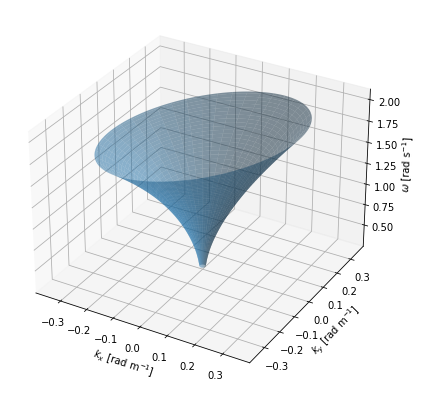

In [8]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=100, z = z, U = U, psi = 0)

In [9]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta

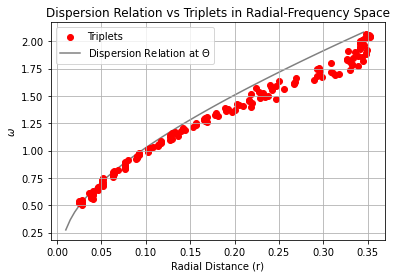

In [10]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

# Consider Exact Dispersion Relation

In [11]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

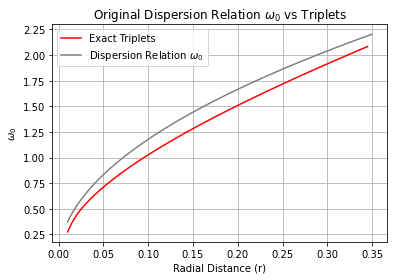

In [12]:
plt.plot(disp_r,disp_ww_for_theta, color = 'red', label = 'Exact Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey', label = 'Dispersion Relation $\omega_{0}$')

#plt.scatter(disp_r, np.sqrt(9.81 * disp_r) +disp_r*Uk[:,0][indices], label='Triplets $\omega$ using Correct U', color = 'red', s = 1)

plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation $\omega_{0}$ vs Triplets")
plt.legend()

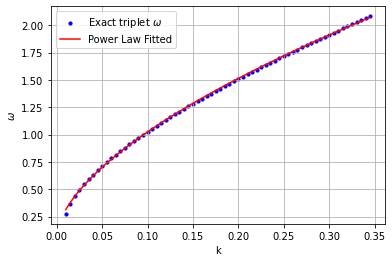

In [13]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, disp_r, disp_ww_for_theta)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(disp_r), max(disp_r), len(disp_r))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(disp_r,disp_ww_for_theta, label='Exact triplet $\omega$ ', s=10, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [14]:
DWL_kx = np.arange(0.01, 0.35, 0.005)
DWL_ky = np.arange(0.01, 0.35, 0.005)

In [15]:
w_0 = np.sqrt( 9.81 * disp_r )
# DWL formula

In [16]:
y_fit

array([0.31349305, 0.37901909, 0.43621713, 0.4879258 , 0.53564272,
       0.58027708, 0.62243187, 0.66253222, 0.70089174, 0.73774993,
       0.77329476, 0.80767715, 0.84102048, 0.87342728, 0.90498382,
       0.93576361, 0.96582988, 0.9952375 , 1.0240345 , 1.05226319,
       1.07996108, 1.10716163, 1.13389485, 1.16018775, 1.18606478,
       1.21154816, 1.23665812, 1.2614132 , 1.2858304 , 1.30992537,
       1.33371256, 1.35720534, 1.38041611, 1.40335642, 1.426037  ,
       1.4484679 , 1.47065851, 1.49261761, 1.51435348, 1.53587389,
       1.55718613, 1.57829713, 1.59921338, 1.61994106, 1.640486  ,
       1.66085373, 1.68104951, 1.70107831, 1.7209449 , 1.74065379,
       1.76020928, 1.77961549, 1.79887634, 1.81799559, 1.83697682,
       1.85582346, 1.87453881, 1.89312602, 1.91158811, 1.92992801,
       1.94814849, 1.96625225, 1.98424186, 2.00211981, 2.0198885 ,
       2.03755024, 2.05510725, 2.07256168])

In [17]:
indices = np.array([]) 
k_reshaped = k.reshape(-1, 1)

# Absolute differences between r and k values
differences = np.abs(disp_r - k_reshaped)

# Indices of the minimum differences for each element in k
indices = np.argmin(differences, axis=0)

In [18]:
w_0+disp_r*Uk[:,0][indices]

array([0.31375866, 0.38478882, 0.44497689, 0.49829019, 0.54675688,
       0.59157766, 0.63353214, 0.67315993, 0.71085259, 0.74690469,
       0.78154432, 0.81495227, 0.84727458, 0.87863122, 0.90912207,
       0.9388313 , 0.96783059, 0.99618152, 1.02393748, 1.05114502,
       1.07784506, 1.10407373, 1.12986316, 1.15524202, 1.18023601,
       1.20486829, 1.2291598 , 1.25312954, 1.2767948 , 1.30017137,
       1.32327373, 1.34611517, 1.36870793, 1.39106332, 1.41319179,
       1.43510304, 1.45680611, 1.47830938, 1.49962069, 1.52074737,
       1.54169628, 1.56247385, 1.58308614, 1.60353884, 1.62383729,
       1.64398656, 1.66399144, 1.68385643, 1.70358583, 1.72318369,
       1.74265386, 1.76200002, 1.78122565, 1.80033406, 1.81932842,
       1.83821175, 1.85698694, 1.87565673, 1.89422377, 1.91269058,
       1.93105958, 1.94933308, 1.96751332, 1.98560243, 2.00360246,
       2.02151538, 2.03934311, 2.05708746])

In [19]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(disp_r))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, disp_r))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [ 0.0279423  -0.3007112  -0.3311222  -0.28749359 -0.22481557 -0.15985311
 -0.09810588 -0.04123046  0.01052672  0.05743839  0.0999478   0.13852828
  0.17362809  0.20565124  0.2349535   0.26184494  0.28659453  0.30943542
  0.33056992  0.35017394  0.36840093  0.38538509  0.40124426  0.41608222
  0.42999069  0.443051    0.45533547  0.46690864  0.47782822  0.48814599
  0.49790849  0.50715768  0.51593141  0.52426394  0.53218631  0.5397267
  0.54691071  0.55376163  0.56030072  0.56654735  0.57251927  0.57823269
  0.58370251  0.58894241  0.59396498  0.59878186  0.6034038   0.60784077
  0.61210203  0.61619621  0.62013137  0.62391505  0.62755432  0.63105582
  0.6344258   0.63767017  0.64079448  0.64380401  0.64670373  0.64949837
  0.6521924   0.65479007  0.65729541  0.65971227  0.66204428  0.6642949
  0.66646745  0.66856504]


In [20]:
Uk[:,0][indices]

array([0.05494615, 0.07916457, 0.10160997, 0.12251859, 0.14208789,
       0.16048329, 0.17784381, 0.1942866 , 0.20991073, 0.22480027,
       0.23902686, 0.25265179, 0.26572774, 0.27830017, 0.29040856,
       0.30208734, 0.31336667, 0.32427316, 0.33483038, 0.34505934,
       0.35497886, 0.36460587, 0.37395571, 0.38304232, 0.39187843,
       0.40047575, 0.40884503, 0.41699626, 0.42493866, 0.43268087,
       0.44023094, 0.4475964 , 0.45478433, 0.46180142, 0.46865395,
       0.47534788, 0.48188883, 0.48828215, 0.49453291, 0.50064595,
       0.50662587, 0.51247703, 0.51820363, 0.52380967, 0.52929895,
       0.53467514, 0.53994173, 0.54510208, 0.55015941, 0.55511678,
       0.55997717, 0.56474342, 0.56941825, 0.57400429, 0.57850408,
       0.58292003, 0.58725449, 0.59150971, 0.59568786, 0.59979103,
       0.60382124, 0.60778043, 0.61167048, 0.6154932 , 0.61925034,
       0.62294359, 0.62657458, 0.63014487])

In [21]:
optimized_U.shape

(68,)

In [22]:
indices = np.array([]) 
k_reshaped = k.reshape(-1, 1)

# Absolute differences between r and k values
differences = np.abs(disp_r - k_reshaped)

# Indices of the minimum differences for each element in k
indices = np.argmin(differences, axis=0)

In [23]:
w_0

array([0.3132092 , 0.38360136, 0.44294469, 0.49522722, 0.54249424,
       0.58596075, 0.62641839, 0.66441704, 0.70035705, 0.73454067,
       0.76720271, 0.7985299 , 0.82867364, 0.85775871, 0.88588938,
       0.91315388, 0.93962759, 0.96537557, 0.99045444, 1.01491379,
       1.03879738, 1.06214406, 1.08498848, 1.10736173, 1.12929181,
       1.15080407, 1.1719215 , 1.19266508, 1.213054  , 1.23310583,
       1.25283678, 1.27226177, 1.2913946 , 1.31024807, 1.32883408,
       1.34716369, 1.36524723, 1.38309436, 1.4007141 , 1.41811495,
       1.43530485, 1.45229129, 1.46908135, 1.48568166, 1.50209853,
       1.51833791, 1.53440542, 1.55030642, 1.56604598, 1.58162891,
       1.5970598 , 1.61234302, 1.62748272, 1.64248288, 1.65734728,
       1.67207954, 1.68668314, 1.70116137, 1.71551741, 1.72975432,
       1.743875  , 1.75788225, 1.77177877, 1.78556714, 1.79924984,
       1.81282928, 1.82630775, 1.83968747])

In [24]:
Uk[:,0][indices]

array([0.05494615, 0.07916457, 0.10160997, 0.12251859, 0.14208789,
       0.16048329, 0.17784381, 0.1942866 , 0.20991073, 0.22480027,
       0.23902686, 0.25265179, 0.26572774, 0.27830017, 0.29040856,
       0.30208734, 0.31336667, 0.32427316, 0.33483038, 0.34505934,
       0.35497886, 0.36460587, 0.37395571, 0.38304232, 0.39187843,
       0.40047575, 0.40884503, 0.41699626, 0.42493866, 0.43268087,
       0.44023094, 0.4475964 , 0.45478433, 0.46180142, 0.46865395,
       0.47534788, 0.48188883, 0.48828215, 0.49453291, 0.50064595,
       0.50662587, 0.51247703, 0.51820363, 0.52380967, 0.52929895,
       0.53467514, 0.53994173, 0.54510208, 0.55015941, 0.55511678,
       0.55997717, 0.56474342, 0.56941825, 0.57400429, 0.57850408,
       0.58292003, 0.58725449, 0.59150971, 0.59568786, 0.59979103,
       0.60382124, 0.60778043, 0.61167048, 0.6154932 , 0.61925034,
       0.62294359, 0.62657458, 0.63014487])

In [25]:
optimized_U

array([ 0.0279423 , -0.3007112 , -0.3311222 , -0.28749359, -0.22481557,
       -0.15985311, -0.09810588, -0.04123046,  0.01052672,  0.05743839,
        0.0999478 ,  0.13852828,  0.17362809,  0.20565124,  0.2349535 ,
        0.26184494,  0.28659453,  0.30943542,  0.33056992,  0.35017394,
        0.36840093,  0.38538509,  0.40124426,  0.41608222,  0.42999069,
        0.443051  ,  0.45533547,  0.46690864,  0.47782822,  0.48814599,
        0.49790849,  0.50715768,  0.51593141,  0.52426394,  0.53218631,
        0.5397267 ,  0.54691071,  0.55376163,  0.56030072,  0.56654735,
        0.57251927,  0.57823269,  0.58370251,  0.58894241,  0.59396498,
        0.59878186,  0.6034038 ,  0.60784077,  0.61210203,  0.61619621,
        0.62013137,  0.62391505,  0.62755432,  0.63105582,  0.6344258 ,
        0.63767017,  0.64079448,  0.64380401,  0.64670373,  0.64949837,
        0.6521924 ,  0.65479007,  0.65729541,  0.65971227,  0.66204428,
        0.6642949 ,  0.66646745,  0.66856504])

In [26]:
w_0+disp_r*optimized_U

array([0.31348862, 0.37909069, 0.43632225, 0.48803988, 0.53574977,
       0.58036589, 0.62249416, 0.66256167, 0.70088339, 0.73769978,
       0.77319958, 0.80753424, 0.84082761, 0.87318255, 0.90468566,
       0.9354107 , 0.96542109, 0.99477194, 1.02351143, 1.05168205,
       1.07932148, 1.10646334, 1.13313779, 1.15937201, 1.1851906 ,
       1.21061595, 1.23566847, 1.26036684, 1.28472823, 1.30876846,
       1.33250214, 1.35594278, 1.37910293, 1.40199426, 1.42462761,
       1.44701313, 1.46916026, 1.49107787, 1.51277425, 1.53425715,
       1.55553389, 1.57661132, 1.5974959 , 1.6181937 , 1.63871048,
       1.65905165, 1.67922234, 1.69922741, 1.71907148, 1.73875894,
       1.75829395, 1.7776805 , 1.79692238, 1.81602323, 1.8349865 ,
       1.85381554, 1.87251354, 1.89108355, 1.90952853, 1.92785132,
       1.94605464, 1.96414112, 1.9821133 , 1.99997362, 2.01772446,
       2.03536807, 2.05290668, 2.07034241])

In [27]:
w_0+disp_r*Uk[:,0][indices]

array([0.31375866, 0.38478882, 0.44497689, 0.49829019, 0.54675688,
       0.59157766, 0.63353214, 0.67315993, 0.71085259, 0.74690469,
       0.78154432, 0.81495227, 0.84727458, 0.87863122, 0.90912207,
       0.9388313 , 0.96783059, 0.99618152, 1.02393748, 1.05114502,
       1.07784506, 1.10407373, 1.12986316, 1.15524202, 1.18023601,
       1.20486829, 1.2291598 , 1.25312954, 1.2767948 , 1.30017137,
       1.32327373, 1.34611517, 1.36870793, 1.39106332, 1.41319179,
       1.43510304, 1.45680611, 1.47830938, 1.49962069, 1.52074737,
       1.54169628, 1.56247385, 1.58308614, 1.60353884, 1.62383729,
       1.64398656, 1.66399144, 1.68385643, 1.70358583, 1.72318369,
       1.74265386, 1.76200002, 1.78122565, 1.80033406, 1.81932842,
       1.83821175, 1.85698694, 1.87565673, 1.89422377, 1.91269058,
       1.93105958, 1.94933308, 1.96751332, 1.98560243, 2.00360246,
       2.02151538, 2.03934311, 2.05708746])

Text(0.5, 0, 'k')

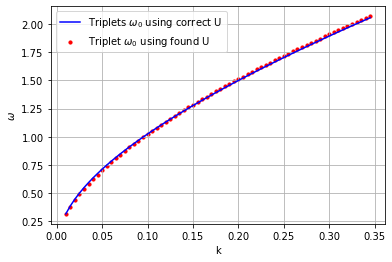

In [28]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(disp_r, w_0+disp_r*Uk[:,0][indices], label="Triplets $\omega_{0}$ using correct U ", color = 'blue',)
plt.scatter(disp_r, w_0+disp_r*optimized_U, label='Triplet $\omega_{0}$ using found U', color = 'red', s = 10)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [29]:
disp_r.shape

(68,)

In [30]:
optimized_U.shape

(68,)

Text(0.5, 0, 'k')

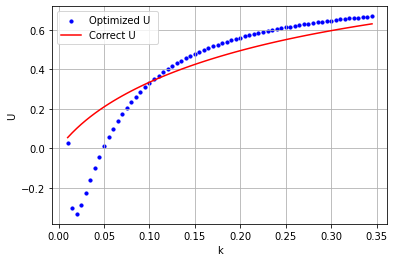

In [31]:
plt.scatter(disp_r, optimized_U, label='Optimized U ', color='blue', s = 10)
plt.plot(disp_r, Uk[:,0][indices], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.15, 0.35)
#plt.ylim(0,1)

# Consider Triplet Values

In [32]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

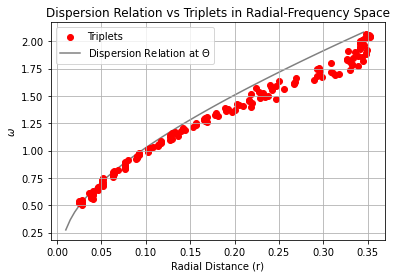

In [33]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

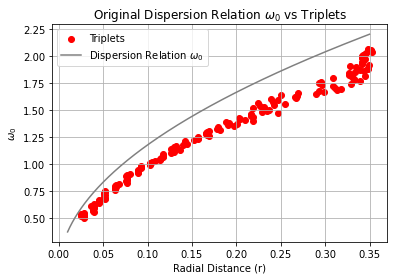

In [34]:
plt.scatter(r, freqs, color = 'red', label = 'Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey', label = 'Dispersion Relation $\omega_{0}$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation $\omega_{0}$ vs Triplets")
plt.legend()

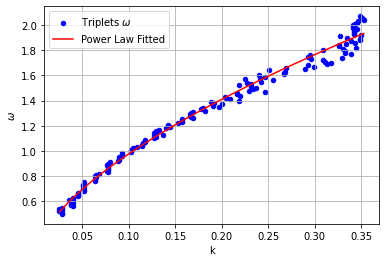

In [35]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, r, freqs)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(r), max(r), len(r))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(r, freqs, label='Triplets $\omega$ ', s=20, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [36]:
kx_0 = r
ky_0 = r
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * r )
# DWL formula

In [37]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(r))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0,r))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [-4.05767692e-01  1.65537564e-01  1.87786909e+00  1.26825214e+00
  3.10368003e+00  2.33556445e+00 -3.49380608e-01  4.02416217e-01
  7.67082447e-01  6.81551689e-01  1.01870268e+00  2.43220809e+00
  1.68320927e+00  2.00935035e+00  1.14125012e+00  1.41855169e+00
  1.69270049e+00  1.96363959e+00  1.08592750e+00  1.31649954e+00
  1.79938379e+00  1.77053611e+00  2.26296584e+00  2.49126281e+00
  2.43461666e+00  2.65173814e+00  1.24509423e+00  1.42007044e+00
  1.59358342e+00  1.61361388e+00  1.93636101e+00  1.94686438e+00
  1.68250932e+00  9.72773163e-01  1.19981732e+00  1.24231059e+00
  1.37570054e+00  1.50818521e+00  1.63977469e+00  1.87170821e+00
  1.90031180e+00  1.74147243e+00  1.17264384e+00  1.21816982e+00
  1.32666923e+00  1.43452285e+00  1.35050751e+00  1.45396304e+00
  1.55681866e+00  1.01752250e+00  1.10912902e+00  1.20024556e+00
  1.15485396e+00  1.03450410e+00  8.27557985e-01  9.07238546e-01
  9.52551225e-01  9.31712773e-01  1.00831179e+00  1.08454114e+00
  7.2

In [38]:
indices = np.array([]) 
k_reshaped = k.reshape(-1, 1)

# Absolute differences between r and k values
differences = np.abs(r - k_reshaped)

# Indices of the minimum differences for each element in k
indices = np.argmin(differences, axis=0)

Text(0.5, 0, 'k')

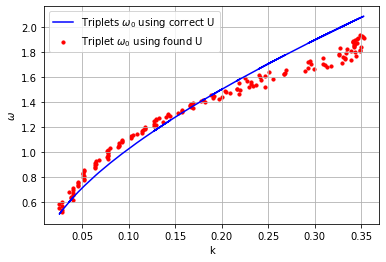

In [39]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(r, w_0+r*Uk[:,0][indices], label="Triplets $\omega_{0}$ using correct U ", color = 'blue',)
plt.scatter(r, w_0+r*optimized_U, label='Triplet $\omega_{0}$ using found U', color = 'red', s = 10)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

Text(0.5, 0, 'k')

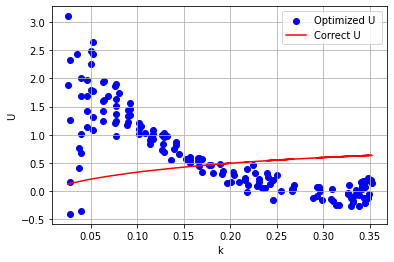

In [40]:
plt.scatter(r, optimized_U, label='Optimized U ', color='blue')
plt.plot(r, Uk[:,0][indices], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.15, 0.35)
#plt.ylim(0,1)

# Try Improve Triplets to be more similar to Dispersion relation

## 1) Dispersion Distribution

In [41]:
FFT_spec = spec3d.spectrum()

In [42]:
def find_indices_thresh(array, threshold):
    indices = []
    for i in range(len(array)):
        for j in range(len(array[i])):
            if array[i][j] > threshold:
                indices.append((i, j))
    return indices

In [43]:
def use_triplet_disrtibution(threshold):
    at_w = np.array([1.85])
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        plt.scatter(k_above_energy, np.full_like(k_above_energy, at_w), color = 'red', s = 1)

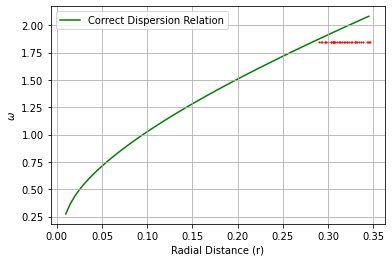

In [44]:
use_triplet_disrtibution(0.1)

plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

In [45]:
def use_triplet_disrtibution(at_w, threshold):
    '''
    
    Find the average k for each triplet distribution
    
        threshold   float
                    threshold energy value that is a point in distribution 
    
        at_w        array
                    the frequencies it gets the distributions at 
    
    '''
    
    
    avg_k = []
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        avg_k.append(sum(k_above_energy)/len(k_above_energy))
        
    return avg_k

In [46]:
under_1 = np.array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.])

In [47]:
between_1_15 = np.array([ 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5])

In [48]:
between_15_2 = np.array([1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.])

In [49]:
above_2 = np.array([2.01, 2.02, 2.03,
       2.04, 2.05, 2.06, 2.07])

In [50]:
no_1 = use_triplet_disrtibution(under_1, 0.62)

no_2 = use_triplet_disrtibution(between_1_15, 6)

no_3 = use_triplet_disrtibution(between_15_2, 0.4)

no_4 = use_triplet_disrtibution(above_2, 0.04)

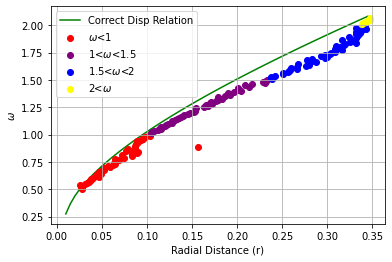

In [51]:
plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Disp Relation')

plt.scatter(no_1, under_1, color='red',zorder=0, label = '$\omega$<1')
plt.scatter(no_2, between_1_15, color='purple',zorder=0, label = '1<$\omega$<1.5')
plt.scatter(no_3, between_15_2, color='blue',zorder=0, label = '1.5<$\omega$<2')
plt.scatter(no_4, above_2, color='yellow',zorder=0, label = '2<$\omega$')

plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

## 2) Find Trips only at one angle (ky = 0)

In [108]:
def plot_k_w_spec(k, w, spec, disp_filter=False, extent=[-0.4,0.4,-3,3], ax=None, cmap='viridis'):  
    ax = plotting_interface.plot_3d_as_2d(k, w, spec, disp_filter, extent, ax, cmap=cmap)    
    ax.set_xlabel(r'$k~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega~[\mathrm{rad~Hz}]$')
    return ax

In [109]:
i=0

<AxesSubplot:xlabel='$k~[\\mathrm{rad~m}^{-1}]$', ylabel='$\\omega~[\\mathrm{rad~Hz}]$'>

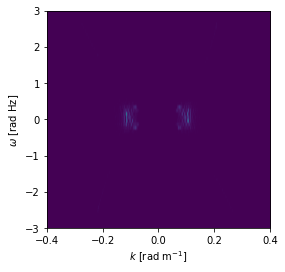

In [110]:
plot_k_w_spec(spec3d.kx, spec3d.w,  FFT_spec[:,:,len(spec3d.ky)//2+i] )

In [111]:
len(spec3d.kx)//2

33

In [112]:
np.log10(abs(FFT_spec[ : , : , len(spec3d.ky)//2 -i]))

array([[-8.38229593, -8.37564642, -8.33797953, ..., -8.19587489,
        -8.33797953, -8.37564642],
       [-8.38226507, -8.37505224, -8.3367971 , ..., -8.19769501,
        -8.33897174, -8.37606166],
       [-8.38229334, -8.37464601, -8.33562668, ..., -8.19960422,
        -8.34012602, -8.37652977],
       ...,
       [-8.38227116, -8.37703544, -8.3412557 , ..., -8.19017865,
        -8.33442271, -8.37412774],
       [-8.38229334, -8.37652977, -8.34012602, ..., -8.19209854,
        -8.33562668, -8.37464601],
       [-8.38226507, -8.37606166, -8.33897174, ..., -8.19399048,
        -8.3367971 , -8.37505224]])

In [113]:
spec3d.w

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])

In [137]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [138]:
FFT_spec = spec3d.spectrum()
# 3d array 

In [139]:
FFT_spec[: ,:, len(spec3d.ky)//2 + 0]

array([[4.14671386e-09, 4.21069304e-09, 4.59219659e-09, ...,
        6.36978989e-09, 4.59219659e-09, 4.21069304e-09],
       [4.14700854e-09, 4.21645779e-09, 4.60471650e-09, ...,
        6.34315007e-09, 4.58171699e-09, 4.20666896e-09],
       [4.14673863e-09, 4.22040363e-09, 4.61714294e-09, ...,
        6.31532614e-09, 4.56955580e-09, 4.20213718e-09],
       ...,
       [4.14695041e-09, 4.19724735e-09, 4.55768489e-09, ...,
        6.45388689e-09, 4.62996052e-09, 4.22544316e-09],
       [4.14673863e-09, 4.20213718e-09, 4.56955580e-09, ...,
        6.42541905e-09, 4.61714294e-09, 4.22040363e-09],
       [4.14700854e-09, 4.20666896e-09, 4.58171699e-09, ...,
        6.39748856e-09, 4.60471650e-09, 4.21645779e-09]])

In [132]:
def plot_k_w_spec(k, w, spec, disp_filter=False, extent=[-0.4, 0.4, -3, 3], ax=None, cmap='viridis'):  
    ax = plotting_interface.plot_3d_as_2d(k, w, spec, disp_filter, extent, ax, cmap=cmap)    
    ax.set_xlabel(r'$k~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega~[\mathrm{rad~Hz}]$')
    return ax

In [133]:
spec3d.w

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])

In [134]:
i = np.argmin(np.abs(spec3d.ky[len(spec3d.ky)//2:] - 0 ))
# as we slice at ky = 0

In [135]:
i

0

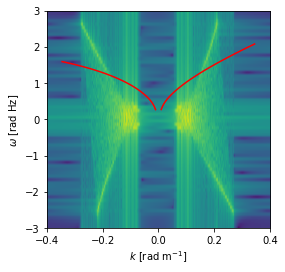

In [136]:
plot_k_w_spec( spec3d.kx , spec3d.w,  np.log10(FFT_spec[ : , : , len(spec3d.ky)//2 + i]))

plt.plot(disp_r_0, disp_ww_for_theta_0, color='red',zorder=0, label = '$\Theta$ = 0')
plt.plot(-disp_r_pi, disp_ww_for_theta_pi, color='red',zorder=0, label = '$\Theta$ = $\pi$')  

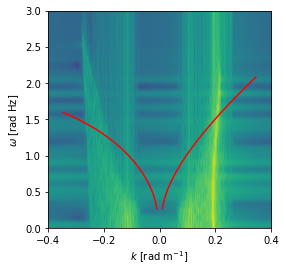

In [65]:
plot_k_w_spec(spec3d.kx, spec3d.w,  np.log10(FFT_spec[ : , : , 51 ]))

plt.plot(disp_r_0, disp_ww_for_theta_0, color='red',zorder=0, label = '$\Theta$ = 0')
plt.plot(-disp_r_pi, disp_ww_for_theta_pi, color='red',zorder=0, label = '$\Theta$ = $\pi$')  

In [66]:
FFT_spec = spec3d.spectrum()
# 3d array 

In [67]:
def plot_kx_w_spec(kx, w, spec, radial_filter=False, extent=[-0.4,0.4,0 , 3], ax=None, colorbar=True, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plotting_interface.plot_3d_as_2d(kx, w, spec, radial_filter, extent, ax, aspect='auto', colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega$')
    return ax

In [68]:
def plot_ky_slice(self, at_ky, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-w spectrum and the integrated k-omega-spectrum
        '''
        if at_ky >= 0:
            i = np.argmin(np.abs(self.ky[len(self.ky)//2:]-at_ky))
            print(at_ky, self.ky[len(self.ky)//2+i], i) 
            plot_kx_w_spec(self.kx, self.w, np.log10( FFT_spec[:,:,len(self.ky)//2+i] ), ax=ax)
        else:
            i = np.argmin(np.abs(self.ky[:len(self.ky)//2]-at_ky))
            print(at_ky, self.ky[i], i) 
            plot_kx_w_spec(self.kx, self.w, np.log10( FFT_spec[:,:,i] ), ax=ax)

0 0.0 0


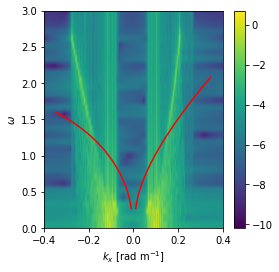

In [69]:
plot_ky_slice(spec3d, 0)

plt.plot(disp_r_0, disp_ww_for_theta_0, color='red',zorder=0, label = '$\Theta$ = 0')
plt.plot(-disp_r_pi, disp_ww_for_theta_pi, color='red',zorder=0, label = '$\Theta$ = $\pi$')  

In [70]:
i = np.argmin(np.abs(spec3d.ky[len(spec3d.ky)//2:]- 0 ))
i

0

In [71]:
energies = FFT_spec[:,:,len(spec3d.ky)//2+i]
energies

array([[4.14671386e-09, 4.21069304e-09, 4.59219659e-09, ...,
        6.36978989e-09, 4.59219659e-09, 4.21069304e-09],
       [4.14700854e-09, 4.21645779e-09, 4.60471650e-09, ...,
        6.34315007e-09, 4.58171699e-09, 4.20666896e-09],
       [4.14673863e-09, 4.22040363e-09, 4.61714294e-09, ...,
        6.31532614e-09, 4.56955580e-09, 4.20213718e-09],
       ...,
       [4.14695041e-09, 4.19724735e-09, 4.55768489e-09, ...,
        6.45388689e-09, 4.62996052e-09, 4.22544316e-09],
       [4.14673863e-09, 4.20213718e-09, 4.56955580e-09, ...,
        6.42541905e-09, 4.61714294e-09, 4.22040363e-09],
       [4.14700854e-09, 4.20666896e-09, 4.58171699e-09, ...,
        6.39748856e-09, 4.60471650e-09, 4.21645779e-09]])

### Improve triplets

In [72]:
def cut_w_gives_kx_energy(w_cut):
    '''Function that cuts at w_cut and displays the kx values against Energies. 
    Also, shows the correct kx values for the dispersion relation at that values '''
    
    index = np.argmin(np.abs(spec3d.w - w_cut))
    # index of nearest value in spec3d.w to w_cut
    
    i = 0
    energies = FFT_spec[:,:,len(spec3d.ky)//2 + i]
    
    energy_slice =  energies[index, :] 
    
    plt.plot(spec3d.kx,  energy_slice )
    
    plt.xlabel("kx")
    plt.ylabel("Energy")
    plt.grid(True)
    
    index1 = np.argmin(np.abs(disp_ww_for_theta_0 - w_cut)) 
    # index of nearest value in spec3d.w to w_cut
    
    plt.axvline(x= -disp_r_0[index1] , color='red', label = 'dispersion relation values')
    
    index2 = np.argmin(np.abs(disp_ww_for_theta_pi - w_cut))
    # index of nearest value in spec3d.w to w_cut
    
    plt.axvline(x= disp_r_pi[index2] , color='red')
    plt.legend(loc = 'upper left')
    
    return energy_slice 

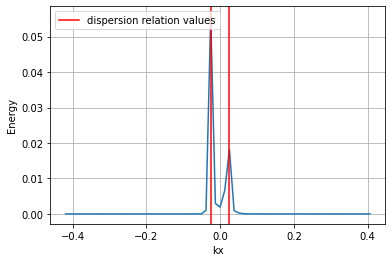

In [73]:
energy_slice = cut_w_gives_kx_energy(0.5)

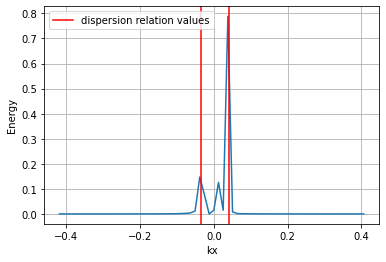

In [74]:
energy_slice = cut_w_gives_kx_energy(0.6)

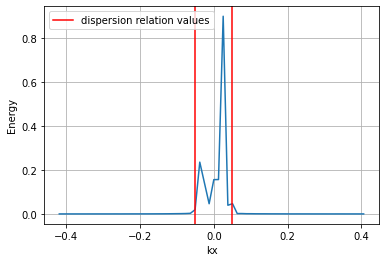

In [75]:
energy_slice = cut_w_gives_kx_energy(0.7)

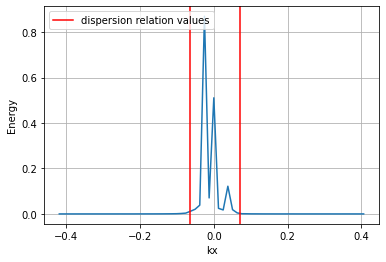

In [76]:
energy_slice = cut_w_gives_kx_energy(0.8)

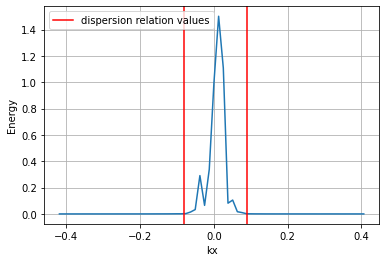

In [77]:
energy_slice = cut_w_gives_kx_energy(0.9)

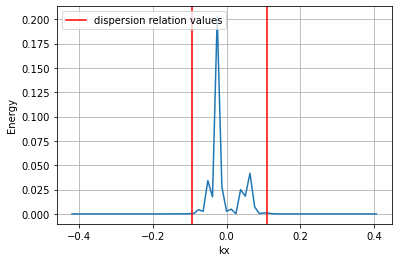

In [78]:
energy_slice = cut_w_gives_kx_energy(1)

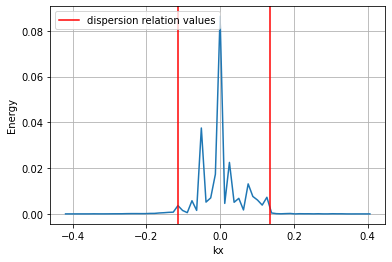

In [79]:
energy_slice = cut_w_gives_kx_energy(1.1)

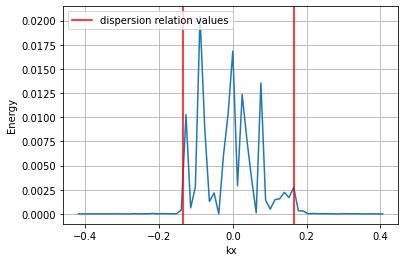

In [80]:
energy_slice = cut_w_gives_kx_energy(1.2)

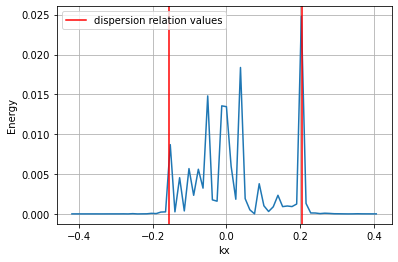

In [81]:
energy_slice = cut_w_gives_kx_energy(1.3)

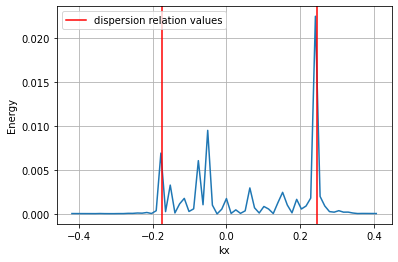

In [82]:
energy_slice = cut_w_gives_kx_energy(1.4)

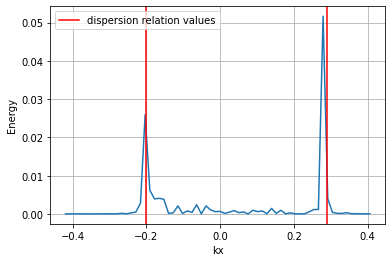

In [83]:
energy_slice = cut_w_gives_kx_energy(1.5)

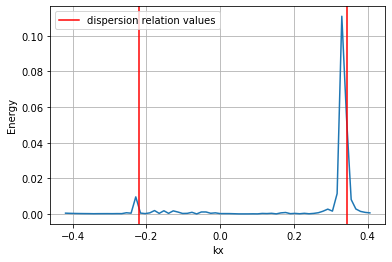

In [84]:
energy_slice = cut_w_gives_kx_energy(1.6)

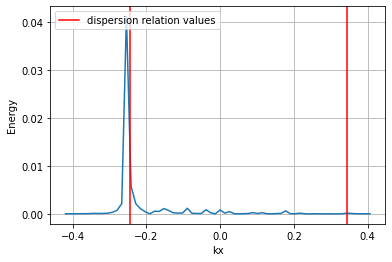

In [85]:
energy_slice = cut_w_gives_kx_energy(1.7)

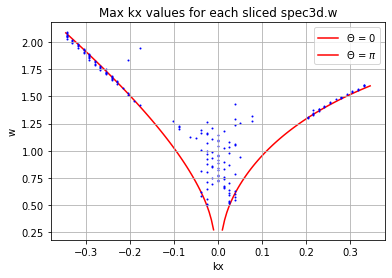

In [86]:
slice_values = np.arange(0.5, 2.1, 0.01)

# empty lists
sliced_w_values = []
max_energy_kx_values = []

# Iterate through slice values
for slice_value in slice_values:
    # Find the index of the closest spec3d.w value to the slice value
    closest_index = np.argmin(np.abs(spec3d.w - slice_value))
    
    # Get the corresponding kx value for the maximum energy at that slice
    max_energy_index = np.argmax(energies[closest_index, :])
    max_energy_kx = spec3d.kx[max_energy_index]
    
    # Append values to the lists
    sliced_w_values.append(spec3d.w[closest_index])
    max_energy_kx_values.append(max_energy_kx)

plt.scatter(max_energy_kx_values, sliced_w_values,  marker='o', color='blue', s=1)

plt.plot(-disp_r_0, disp_ww_for_theta_0, color='red',zorder=0, label = '$\Theta$ = 0')
plt.plot(disp_r_pi, disp_ww_for_theta_pi, color='red',zorder=0, label = '$\Theta$ = $\pi$')  

plt.title('Max kx values for each sliced spec3d.w')
plt.xlabel('kx')
plt.ylabel('w')
plt.grid(True)
plt.legend()
plt.show()

# Try other data

In [156]:
f = h5py.File('shearing_curr_res_7.5_dt_1.0_T_600_U_1.0exp(0.2z)+0.05_psi_30_smax_10_0_surf3d.hdf5', 'r')

In [157]:
surf3d = surface_core.surface_from_file("shearing_curr_res_7.5_dt_1.0_T_600_U_1.0exp(0.2z)+0.05_psi_30_smax_10_0_surf3d.hdf5")

In [158]:
spec3d = surf3d.define_SpectralAnalysis()

In [159]:
FFT_spec = spec3d.spectrum()
# 3d array

In [160]:
def plot_k_w_spec(k, w, spec, disp_filter=False, extent=[-0.4, 0.4, -3, 3], ax=None, cmap='viridis'):  
    ax = plotting_interface.plot_3d_as_2d(k, w, spec, disp_filter, extent, ax, cmap=cmap)    
    ax.set_xlabel(r'$k~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega~[\mathrm{rad~Hz}]$')
    return ax

<AxesSubplot:xlabel='$k~[\\mathrm{rad~m}^{-1}]$', ylabel='$\\omega~[\\mathrm{rad~Hz}]$'>

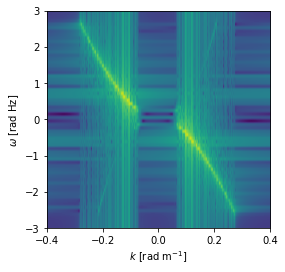

In [161]:
plot_k_w_spec( spec3d.kx , spec3d.w,  np.log10(FFT_spec[ :,: , len(spec3d.ky)//2 + i]))

<AxesSubplot:xlabel='$k~[\\mathrm{rad~m}^{-1}]$', ylabel='$\\omega~[\\mathrm{rad~Hz}]$'>

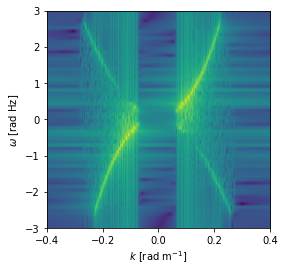

In [162]:
plot_k_w_spec( spec3d.kx , spec3d.w,  np.log10(FFT_spec[ :, len(spec3d.kx)//2 + i, :]))

In [87]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# Defines the gaussian function with paramerters a, x0 and sigma

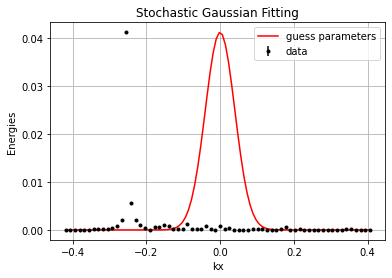

In [88]:
# plot the raw data
plt.errorbar(spec3d.kx, energy_slice, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('kx')
plt.ylabel('Energies')


# initial guess
pars0 = (max(energy_slice), 0,0.04)

# overlay gaussian
x = np.linspace( min(spec3d.kx), max(spec3d.kx), 100)
         
plt.plot(x, gaus(x,*pars0), color = 'red', label = 'guess parameters')
plt.legend();
plt.title("Stochastic Gaussian Fitting");

The covariance matrix is: 
 [[ 1.96273855  0.51795785 -0.22447873]
 [ 0.51795785  0.30363882 -0.10178444]
 [-0.22447873 -0.10178444  0.08382964]] 

 a vlaue (best-fit) = 0.042 ± 1.4
 x0 value (best-fit) = -0.25 ± 0.55
 sigma value (best-fit) = 0.0057 ± 0.29


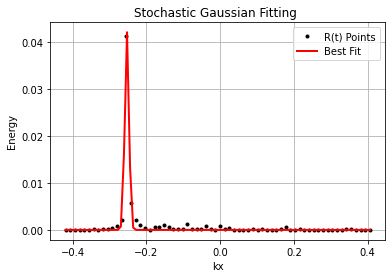

In [89]:
# perform fitting
popt, pcov = curve_fit(gaus, spec3d.kx, energy_slice,  absolute_sigma=True, p0=pars0)

print("The covariance matrix is: \n", pcov, "\n")

# extract best-fit parameter and its error
a_opt = popt[0]
x0_opt = popt[1]
sigma_opt = popt[2]
a_opt_err = np.sqrt(pcov[0, 0])
x0_opt_err = np.sqrt(pcov[1, 1])
sigma_opt_err = np.sqrt(pcov[2, 2])

print(f" a vlaue (best-fit) = {a_opt:.2g} ± {a_opt_err:.2g}")
print(f" x0 value (best-fit) = {x0_opt:.2g} ± {x0_opt_err:.2g}")
print(f" sigma value (best-fit) = {sigma_opt:.2g} ± {sigma_opt_err:.2g}")

# plot data
plt.plot(spec3d.kx, energy_slice, 'ko', markersize=3, label = 'R(t) Points')

# creating x interval to include in y fit
x = np.linspace(min(spec3d.kx), max(spec3d.kx), 100)
y_fit = gaus(x, *popt)
plt.plot(x, y_fit, color="red", label="Best Fit", linewidth=2)


plt.grid(True)
plt.xlabel("kx")
plt.ylabel("Energy")
plt.title("Stochastic Gaussian Fitting ")
plt.legend();

In [90]:
np.argmax( energies[ind,:] )
# index of maximum energy

NameError: name 'ind' is not defined

In [91]:
spec3d.kx[31]

-0.025386607301735697

In [92]:
spec3d.kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

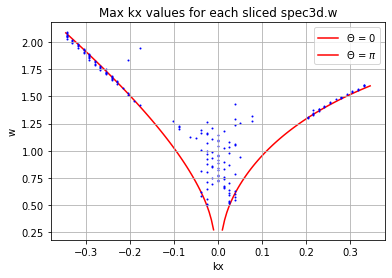

In [93]:
slice_values = np.arange(0.5, 2.1, 0.01)

# empty lists
sliced_w_values = []
max_energy_kx_values = []

# Iterate through slice values
for slice_value in slice_values:
    # Find the index of the closest spec3d.w value to the slice value
    closest_index = np.argmin(np.abs(spec3d.w - slice_value))
    
    # Get the corresponding kx value for the maximum energy at that slice
    max_energy_index = np.argmax(energies[closest_index, :])
    max_energy_kx = spec3d.kx[max_energy_index]
    
    # Append values to the lists
    sliced_w_values.append(spec3d.w[closest_index])
    max_energy_kx_values.append(max_energy_kx)

plt.scatter(max_energy_kx_values, sliced_w_values,  marker='o', color='blue', s=1)

plt.plot(-disp_r_0, disp_ww_for_theta_0, color='red',zorder=0, label = '$\Theta$ = 0')
plt.plot(disp_r_pi, disp_ww_for_theta_pi, color='red',zorder=0, label = '$\Theta$ = $\pi$')  

plt.title('Max kx values for each sliced spec3d.w')
plt.xlabel('kx')
plt.ylabel('w')
plt.grid(True)
plt.legend()
plt.show()

In [94]:
def plot_disp_surf_at_angle(spec_theta, h, z, U, psi):

# (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]

    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation at $\Theta$")
    plt.legend()
    
    return kx, ky, disp_r, disp_ww_for_theta

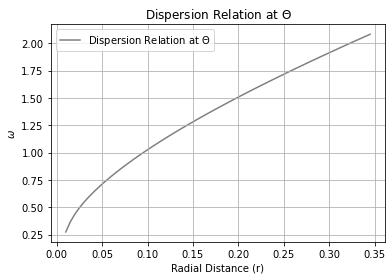

In [95]:
kx, ky, disp_r_0, disp_ww_for_theta_0 = plot_disp_surf_at_angle(0, h = 100, z=z, U=U, psi = 0)

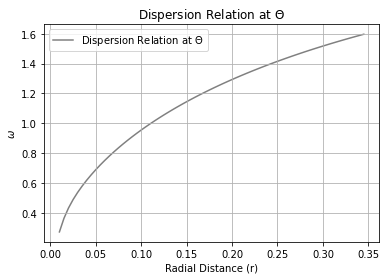

In [96]:
kx, ky, disp_r_pi, disp_ww_for_theta_pi = plot_disp_surf_at_angle(np.pi, h = 100, z=z, U=U, psi = 0)

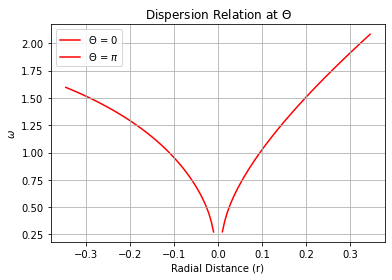

In [62]:
plt.plot(disp_r_0, disp_ww_for_theta_0, color='red',zorder=0, label = '$\Theta$ = 0')
plt.plot(-disp_r_pi, disp_ww_for_theta_pi, color='red',zorder=0, label = '$\Theta$ = $\pi$')    
    
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation at $\Theta$")
plt.legend()

In [63]:
Spectrum.estimate_dispersion_cone(spec3d, h=100, Umax=0.7)

AttributeError: module 'wave_tools.Spectrum' has no attribute 'estimate_dispersion_cone'

In [ ]:
Nt = 1200

In [ ]:
estimate_dispersion_cone(spec3d, h=100, Umax=0.7)